In [ ]:
# import necessary modules
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision import models
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [1]:
#Mounting Google Drive to access Dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Reading content of dataset
plastics_dir = '/content/drive/MyDrive/Project_Dataset'
classes = os.listdir(plastics_dir)
print(classes)

['High-Density Polyethylene (HD-PE)', 'OTHER', 'Polystyrene (PS)', 'Polyethylene Terephthalate  (PETE)', 'Polypropylene (PP)']


In [ ]:
#Resizing images and getting dataset length
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = ImageFolder(plastics_dir, transform=transformations)
print("Length of the dataset : ", len (dataset)) 

Length of the dataset :  4000


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
  print("Label: ", dataset.classes[label], "(Class No: " +str(label)+ ")")
  plt.imshow(img.permute(1, 2, 0))

Label:  High-Density Polyethylene (HD-PE) (Class No: 0)


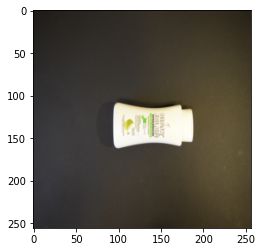

In [ ]:
# Showing sample dataset
img, label = dataset[260]
show_sample(img, label)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

   

In [ ]:
#Splitting the dataset into three
train_ds, val_ds,test_ds = random_split(dataset, [3000, 200,800])
print("Lenght of train dataset :" , len(train_ds))
print("Lenght of validation  dataset :" , len(val_ds))
print("Lenght of test dataset :" , len(test_ds))

Lenght of train dataset : 3000
Lenght of validation  dataset : 200
Lenght of test dataset : 800


In [ ]:
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

batch_size = 32

In [ ]:
#Creating Dataloaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=False)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


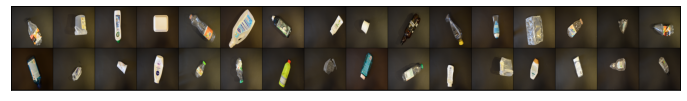

In [ ]:
#Showing sample grid of the Train Dataset
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

show_batch(train_dl)

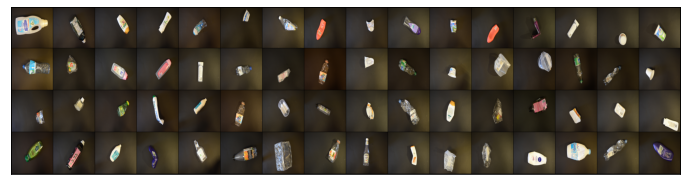

In [ ]:
#Showing sample grid of the Validation Dataset
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

show_batch(val_dl)

In [ ]:
def accuracy(output, labels):
  _, preds = torch.max(output, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, label = batch
    out = self(images)                    # Generate Prediction
    loss = F.cross_entropy(out, label)   # Calculate Loss
    return loss

  def validation_step(self, batch):
    images, label = batch
    out = self(images)                    # Generate Predictions
    loss = F.cross_entropy(out, label)   # Calculate Loss
    acc = accuracy(out, label)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()     # Combine Losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()        # Combine Accuracy
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#Using ResNet50 as the classification Base
class ResNet(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    # use a pre-trained model
    self.network = models.resnet50(pretrained=True)
    # replace last layer
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

  def forward(self, xb):
    return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
import torch.optim as optim

In [ ]:
# function for fitting the model
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    # training phase
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
model = to_device(ResNet(), device)

In [ ]:
#Performing an evaluation of the Model
evaluate(model, val_dl)

{'val_loss': 1.6204702854156494, 'val_acc': 0.12890625}

In [ ]:
# Training the Model with 10 epochs and using Adam Optimizer
num_epochs = 10
opt_func = torch.optim.Adam
lr=5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl,opt_func)


Epoch 1: train_loss: 1.1269, val_loss: 0.9976, val_acc: 0.9336
Epoch 2: train_loss: 0.9527, val_loss: 0.9671, val_acc: 0.9570
Epoch 3: train_loss: 0.9269, val_loss: 0.9235, val_acc: 0.9883
Epoch 4: train_loss: 0.9194, val_loss: 0.9134, val_acc: 1.0000
Epoch 5: train_loss: 0.9135, val_loss: 0.9208, val_acc: 0.9883
Epoch 6: train_loss: 0.9116, val_loss: 0.9157, val_acc: 0.9961
Epoch 7: train_loss: 0.9122, val_loss: 0.9223, val_acc: 0.9609
Epoch 8: train_loss: 0.9095, val_loss: 0.9238, val_acc: 0.9922
Epoch 9: train_loss: 0.9133, val_loss: 0.9141, val_acc: 1.0000
Epoch 10: train_loss: 0.9117, val_loss: 0.9089, val_acc: 1.0000


In [ ]:
# Saving the Trained Model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ResNet50.pth')

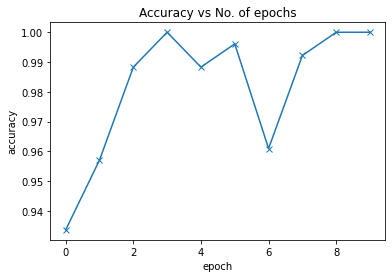

In [ ]:
# Plotting the Accuracies 
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of epochs')

plot_accuracies(history)

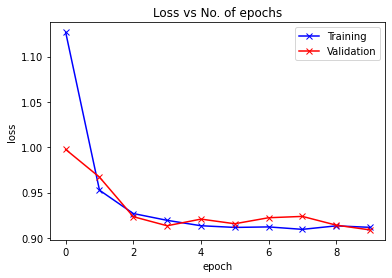

In [26]:
# Plotting the Losses
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs No. of epochs')

plot_losses(history)

In [27]:
def predict_plastic(img, model):
  # convert to a batch of one
  xb = to_device(img.unsqueeze(0), device)
  # get prediction from the model
  yb = model(xb)
  # pick index with the highest probability
  prob, preds = torch.max(yb, dim=1)
  # Retrieve the class label
  return dataset.classes[preds[0].item()]

Label: Polystyrene (PS) 
Predicted: Polystyrene (PS)


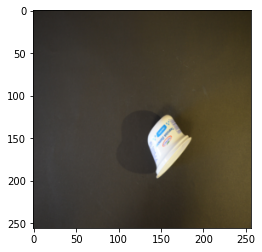

In [28]:
img, label = test_ds[27]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], '\nPredicted:', predict_plastic(img, model))

Label: Polyethylene Terephthalate  (PETE) 
Predicted: Polyethylene Terephthalate  (PETE)


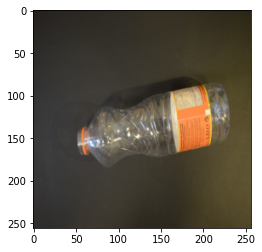

In [29]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], '\nPredicted:', predict_plastic(img, model))

Label: Polypropylene (PP) 
Predicted: Polypropylene (PP)


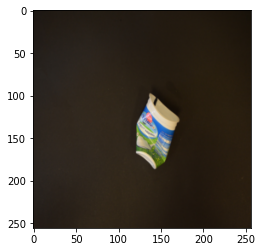

In [30]:
img, label = test_ds[37]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], '\nPredicted:', predict_plastic(img, model))

Label: High-Density Polyethylene (HD-PE) 
Predicted: High-Density Polyethylene (HD-PE)


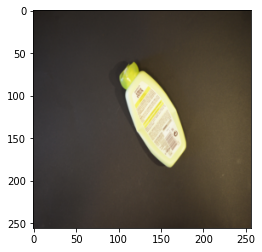

In [31]:
img, label = test_ds[434]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], '\nPredicted:', predict_plastic(img, model))